### Setup

In [ ]:
!pip install imageio
#!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
from IPython import display

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LABEL = "1"
BASE_PATH = '/content/drive/MyDrive/Projects/improving-breast-cancer-detection-accuracy-of-convolutional-neural-networks'
INPUT_PATH = BASE_PATH + f'/data/original/{LABEL}'
OUTPUT_PATH = BASE_PATH + f'/data/lsgan/{LABEL}'
MODEL_PATH = BASE_PATH + f'/models/lsgan/{LABEL}'
CHKPT_PATH = MODEL_PATH + '/checkpoints'

IMG_DEPTH = 3
IMG_WIDTH = 320
IMG_HEIGHT = 320

BUFFER_SIZE = 1170
BATCH_SIZE = 30

EPOCHS = 250
RANDOM_LENGTH = 100
IMAGES_TO_GENERATE = BUFFER_SIZE

### Load and prepare the dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    INPUT_PATH,
    labels=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(320, 320),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1170 files belonging to 1 classes.


In [ ]:
train_images = []
for images in train_ds:
    for i in range(len(images)):
      train_images.append(images[i])

train_images = np.array(train_images)
train_images = train_images.reshape(train_images.shape[0],IMG_WIDTH,IMG_HEIGHT,IMG_DEPTH).astype('float32')

train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    noise_shape = (RANDOM_LENGTH,)
    model = tf.keras.Sequential()
    model.add(layers.Dense(256 * 20 * 20, use_bias=False, input_shape=noise_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((20, 20, 256)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.5))
    model.add(layers.LeakyReLU())
        
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.5))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.5))
    model.add(layers.LeakyReLU())
        
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(32, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.5))
    model.add(layers.Activation("relu"))
        
    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.5))
    model.add(layers.Activation("tanh"))

    return model


Use the (as yet untrained) generator to create an image.

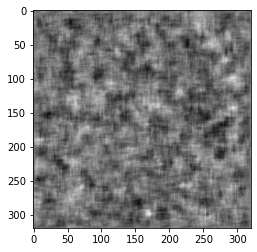

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(32, kernel_size=3, input_shape=(IMG_WIDTH,IMG_HEIGHT,IMG_DEPTH), padding="same"))
    model.add(layers.LeakyReLU())
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.LeakyReLU())
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.LeakyReLU())
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    model.add(layers.LeakyReLU())
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49955288]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()#from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = mse(tf.ones_like(real_output), real_output)
    fake_loss = mse(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
discriminator_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_prefix = os.path.join(CHKPT_PATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
seed = tf.random.normal([9, RANDOM_LENGTH])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, RANDOM_LENGTH])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #Save the final version
  if (epoch + 1) % 15 != 0: #If this is zero, it would have been saved earlier
      checkpoint.save(file_prefix = checkpoint_prefix)
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  #Generate the complete list of images
  noise = tf.random.normal([IMAGES_TO_GENERATE, RANDOM_LENGTH])
  for i in range(0, IMAGES_TO_GENERATE, BATCH_SIZE):
    save_final_images(generator,
                    epochs,
                    noise[i:i+BATCH_SIZE],
                    i)

### Generate and save images


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 12))


  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def save_final_images(model, epoch, test_input, start_index):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  for i in range(predictions.shape[0]):
    f = f'{OUTPUT_PATH}/lsgan_{start_index+i+1:04}.png'
    prd = ((predictions[i, :, :, 0] * 127.5) + 127.5)
    arr = prd.numpy().astype(np.uint8)
    img = Image.fromarray(arr, 'L')
    img = img.convert('RGB')
    img.save(f)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images start looking increasingly real. We train for 100 epochs. This may take about 30 seconds for each epoch with the default settings on Colab.

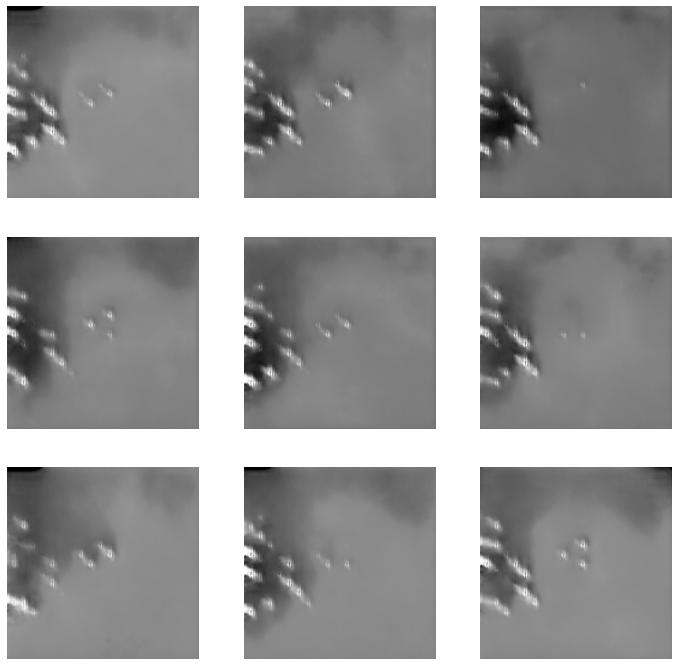

In [ ]:
train(train_dataset, EPOCHS)

### Save the generator model

In [ ]:
generator.save(f'{MODEL_PATH}/generator.h5')

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = f'{MODEL_PATH}/lsgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)